<a href="https://colab.research.google.com/github/dong-uk-kim97/Aiffel_project/blob/main/GoingDeeper_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ! pip uninstall -y tensorflow
# ! pip uninstall -y numpy
# ! pip uninstall -y keras
# ! pip uninstall -y tensorflow_datasets
# ! pip install  tensorflow==2.6.0
# ! pip install keras==2.6.0
# ! pip install  numpy==1.21.4
# ! pip install tensorflow_datasets==4.4.0

In [ ]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
print(np.__version__)
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
print(tfds.__version__)
# from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model

2.6.0
1.21.4
4.4.0


# 1. cats_vs_dogs dataset load and preprocessing


In [ ]:
import urllib3
urllib3.disable_warnings()
# dataset load
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
    data_dir='/content/drive/MyDrive'
)

In [ ]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [ ]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [ ]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=1)
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
ds_info.features['label'].num_classes

2

In [ ]:
ds_info.features['label'].names

['cat', 'dog']

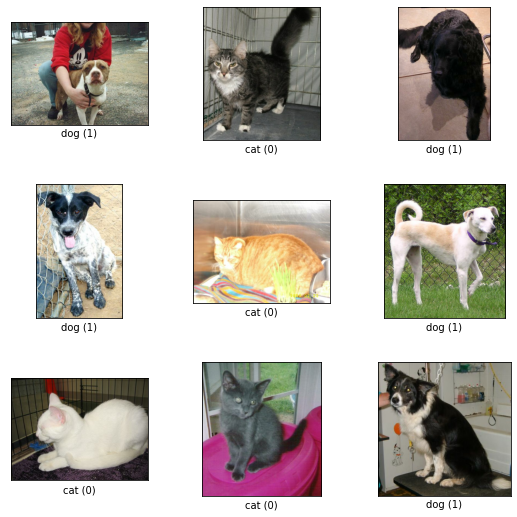

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)

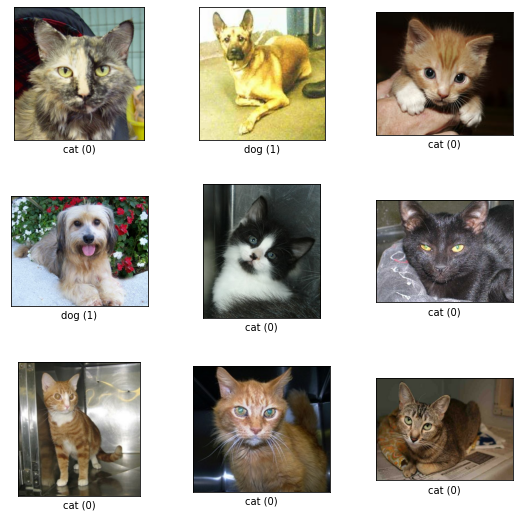

In [ ]:
fig = tfds.show_examples(ds_test, ds_info)

# 2. ResNet block build


In [ ]:
def resnet_residual(x,
                    channel,
                    kernel_size=3,
                    stride=1,
                    conv_shortcut=False,
                    is_plain=False):
    # x : Input
    # y : F(x) = H(x) - x
    # H(x) = F(x) + x

    # skip-connection
    # when the dimensions increase
    if conv_shortcut:
        shortcut = tf.keras.layers.Conv2D(filters=channel, kernel_size=1, strides=stride, padding='same')(x)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

        y = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=2, padding='same')(x)
        y = tf.keras.layers.BatchNormalization()(y)
        y = tf.keras.layers.ReLU()(y)

        y = tf.keras.layers.Conv2D(channel, 3, strides=1, padding='same')(y)
        y = tf.keras.layers.BatchNormalization()(y)

    else:
        shortcut = x
        
        y = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(x)
        y = tf.keras.layers.BatchNormalization()(y)
        y = tf.keras.layers.ReLU()(y)

        y = tf.keras.layers.Conv2D(channel, 3, strides=1, padding='same')(y)
        y = tf.keras.layers.BatchNormalization()(y)

    if is_plain:
        y = tf.keras.layers.ReLU()(y)

        return y
    else:
        x = tf.keras.layers.Add()([y, shortcut]) # skip
        x = tf.keras.layers.ReLU()(x)

        return x

In [ ]:
def resnet_bottleneck(x,
                      channel,
                      kernel_size=3,
                      stride=1,
                      conv_shortcut=False,
                      is_plain=False):
    
    # x : Input
    # y : F(x) = H(x) - x
    # H(x) = F(x) + x

    # skip-connection
    # when the dimensions increase
    if conv_shortcut:
        shortcut = tf.keras.layers.Conv2D(channel * 4, 1, strides=stride, padding='same')(x)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

        y = tf.keras.layers.Conv2D(channel, 1, strides=stride, padding='same')(x)
        y = tf.keras.layers.BatchNormalization()(y)
        y = tf.keras.layers.ReLU()(y)

        y = tf.keras.layers.Conv2D(channel, 3, strides=1, padding='same')(y)
        y = tf.keras.layers.BatchNormalization()(y)
        y = tf.keras.layers.ReLU()(y)
        
        y = tf.keras.layers.Conv2D(channel * 4, 1, strides=1, padding='same')(y)
        y = tf.keras.layers.BatchNormalization()(y)

    else:
        shortcut = x

        y = tf.keras.layers.Conv2D(channel, 1, strides=1, padding='same')(x)
        y = tf.keras.layers.BatchNormalization()(y)
        y = tf.keras.layers.ReLU()(y)

        y = tf.keras.layers.Conv2D(channel, 3, strides=1, padding='same')(y)
        y = tf.keras.layers.BatchNormalization()(y)
        y = tf.keras.layers.ReLU()(y)
        
        y = tf.keras.layers.Conv2D(channel * 4, 1, strides=1, padding='same')(y)
        y = tf.keras.layers.BatchNormalization()(y)

    if is_plain:
        y = tf.keras.layers.ReLU()(y)
        return y
    else:
        x = tf.keras.layers.Add()([y, shortcut])
        x = tf.keras.layers.ReLU()(x)
        return x


In [ ]:
def build_resnet_blocks(input_layer, 
                        num_cnn=3,      # number of CNN                 , [3, 4, 6, 3]
                        channel=64,     # number of channels in a filter, [64, 128, 256, 512]
                        strides=1,      # strides
                        block_num=0,    # block number name, Start with conv2.
                        is_plain=False, # plane or residual? 
                        is_50=False):   # resnet34 or resnet50?
    # input layer
    x = input_layer

    # Resnet50
    if is_50:
        for cnn_num in range(num_cnn):
            if block_num == 2 and cnn_num == 0:     # 첫번째 블럭의 첫번째 convnet; 1x1 -> 3x3 -> 1x1 ch : 256
                x = resnet_bottleneck(x, channel, conv_shortcut=True, is_plain=is_plain)
            elif block_num != 2 and cnn_num == 0:   # 점선
                x = resnet_bottleneck(x, channel, stride=2, conv_shortcut=True, is_plain=is_plain)
            else:                                   # 실선
                x = resnet_bottleneck(x, channel, is_plain=is_plain)

    # Resnet34
    else:# 3 input
        for cnn_num in range(num_cnn):
            if block_num != 2 and cnn_num == 0: # 점선
                x = resnet_residual(x, channel, stride=2, conv_shortcut=True, is_plain=is_plain)
            else: # 실선
                x = resnet_residual(x, channel, is_plain=is_plain)
        
    return x

In [ ]:
def build_resnet(input_shape=(224, 224, 3), 
                 num_cnn_list=[3, 4, 6, 3], 
                 channel_list=[64, 128, 256, 512], 
                 num_classes=10, 
                 is_plain=False, 
                 is_50=False):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = tf.keras.layers.Input(shape=input_shape)
    output = input_layer
    
    # layer name : conv1 : Conv -> BN -> ReLU -> MaxPooling
    output = tf.keras.layers.Conv2D(64, kernel_size=(7, 7), strides=2, padding='same', name='conv1')(output)
    output = tf.keras.layers.BatchNormalization()(output)
    output = tf.keras.layers.ReLU()(output)
    output = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2, padding='same', name='conv1_maxpool2d')(output)
    
    # layer name : conv2_x, conv3_x, conv4_x, conv5_x,
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_blocks(output,
                                     num_cnn=num_cnn,   # number of CNN
                                     channel=channel,   # number of channels in a filter
                                     block_num=i+2,     # block number name
                                     is_plain=is_plain, # plane or residual? 
                                     is_50=is_50)       # resnet34 or resnet50?

    # Flatten and Dense Layer
    output = tf.keras.layers.GlobalAveragePooling2D(name='average_pooling')(output)
    output = tf.keras.layers.Flatten(name='flatten')(output)
    output = tf.keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    
    return model

# 3.1 ResNet 34 Residual Model

In [ ]:
resnet34 = build_resnet(input_shape=(224, 224, 3), num_classes=2)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 112, 112, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

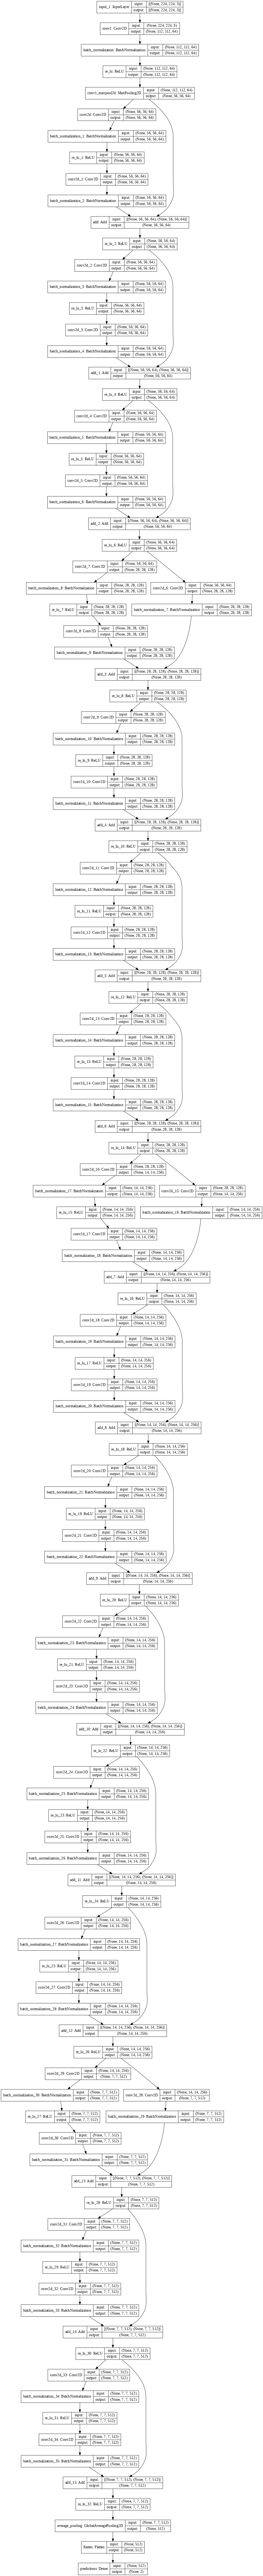

In [ ]:
resnet34.summary()
tf.keras.utils.plot_model(resnet34, show_shapes=True, dpi=70)

# 3.2 ResNet 34 Plain model

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_36 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
re_lu_33 (ReLU)              (None, 112, 112, 64)      0         
_________________________________________________________________
conv1_maxpool2d (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_37 (Batc (None, 56, 56, 64)        256 

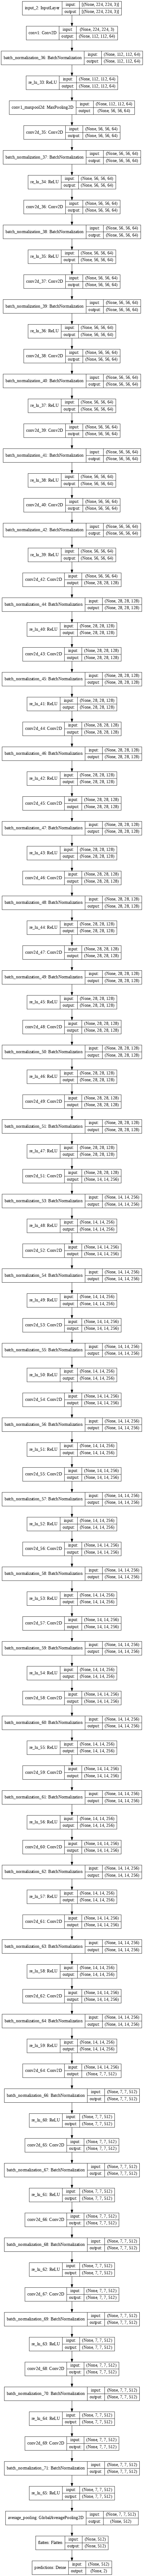

In [ ]:
resnet34_plain = build_resnet(input_shape=(224, 224, 3), is_plain=True, num_classes=2)
resnet34_plain.summary()
tf.keras.utils.plot_model(resnet34_plain, show_shapes=True, dpi=70)

# 3.3 ResNet 34 Plain and Residual Model Train

In [ ]:
BATCH_SIZE = 32
EPOCH = 50
# cats_vs_dogs dataset load
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


# 3.3 ResNet 34 Plain and Residual Model Train


In [ ]:
# ResNet34 Plain
resnet34_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34_plain = resnet34_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
581/581 [==============================] - 97s 124ms/step - loss: 0.6964 - accuracy: 0.5469 - val_loss: 0.7373 - val_accuracy: 0.4903
Epoch 2/50
581/581 [==============================] - 69s 119ms/step - loss: 0.6890 - accuracy: 0.5543 - val_loss: 0.7924 - val_accuracy: 0.5348
Epoch 3/50
581/581 [==============================] - 69s 118ms/step - loss: 0.6738 - accuracy: 0.5899 - val_loss: 0.8417 - val_accuracy: 0.5377
Epoch 4/50
581/581 [==============================] - 69s 118ms/step - loss: 0.6629 - accuracy: 0.6059 - val_loss: 0.8930 - val_accuracy: 0.5580
Epoch 5/50
581/581 [==============================] - 69s 118ms/step - loss: 0.6552 - accuracy: 0.6168 - val_loss: 0.6605 - val_accuracy: 0.6208
Epoch 6/50
581/581 [==============================] - 69s 118ms/step - loss: 0.6486 - accuracy: 0.6230 - val_loss: 0.7031 - val_accuracy: 0.5705
Epoch 7/50
581/581 [==============================] - 68s 118ms/step - loss: 0.6372 - accuracy: 0.6371 - val_loss: 0.6497 - val_ac

In [ ]:
# ResNet34 Residual
resnet34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34_residual = resnet34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test, 
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
581/581 [==============================] - 85s 123ms/step - loss: 0.6491 - accuracy: 0.6337 - val_loss: 0.8825 - val_accuracy: 0.5043
Epoch 2/50
581/581 [==============================] - 70s 121ms/step - loss: 0.5877 - accuracy: 0.6897 - val_loss: 0.7849 - val_accuracy: 0.5692
Epoch 3/50
581/581 [==============================] - 70s 121ms/step - loss: 0.5322 - accuracy: 0.7346 - val_loss: 0.7559 - val_accuracy: 0.6293
Epoch 4/50
581/581 [==============================] - 71s 121ms/step - loss: 0.4935 - accuracy: 0.7594 - val_loss: 0.5415 - val_accuracy: 0.7373
Epoch 5/50
581/581 [==============================] - 70s 121ms/step - loss: 0.4288 - accuracy: 0.8005 - val_loss: 0.6868 - val_accuracy: 0.6758
Epoch 6/50
581/581 [==============================] - 70s 121ms/step - loss: 0.3724 - accuracy: 0.8321 - val_loss: 0.8305 - val_accuracy: 0.6684
Epoch 7/50
581/581 [==============================] - 70s 121ms/step - loss: 0.3049 - accuracy: 0.8692 - val_loss: 0.4451 - val_ac

# 3.4 ResNet 34 Plain and Residual Model Compare Result


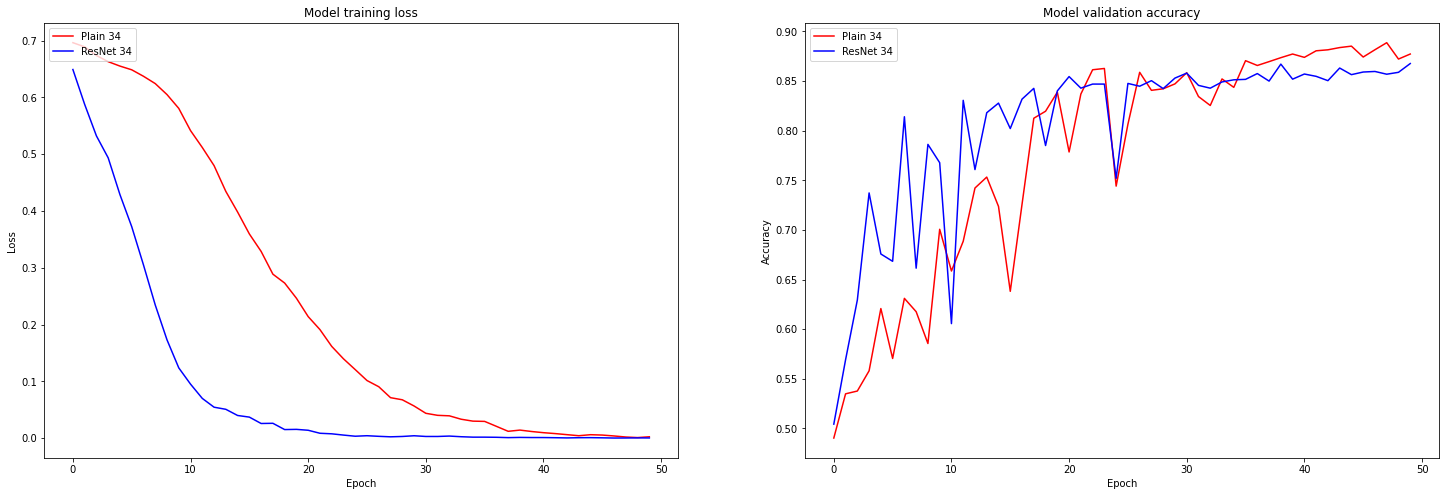

In [ ]:
# 시각화
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(25, 8))

plt.subplot(1, 2, 1)
plt.plot(history_34_plain.history['loss'], 'r')
plt.plot(history_34_residual.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Plain 34', 'ResNet 34'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_34_plain.history['val_accuracy'], 'r')
plt.plot(history_34_residual.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain 34', 'ResNet 34'], loc='upper left')
plt.show()

Training loss에서는 resnet이 plain과는 다르게 빠르게 감소하는 모습을 보여준다. 하지만 validation loss에서는 조금 더 안 좋게 나오는데 이 이유는 2가지가 예상된다.

우선, 많은 epoch로 인해 과적합되었다는 것이다. resnet과 plain 모두 training accuracy가 99를 상회하는 모습을 보인다. 그에 비해 validation accuracy는 10% 넘게 차이가 나는데 이를 통해 과적합되었음을 알 수 있다.

두번째, dataset의 차이이다. ImageNet의 경우 약 120만장이 넘는 training set, 5만장의 validation set, 10만장의 test set인 반면에 'cats vs dogs'는 1만 8천장의 training set, 약 5천장의 validation set으로 구성되어 있다. 이를 보면 model complexity가 dataset에 비해 높다는 추측이 가능하다.

# 4.1 ResNet 50 Residual Model

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_72 (BatchNo (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
re_lu_66 (ReLU)                 (None, 112, 112, 64) 0           batch_normalization_72[0][0]     
____________________________________________________________________________________________

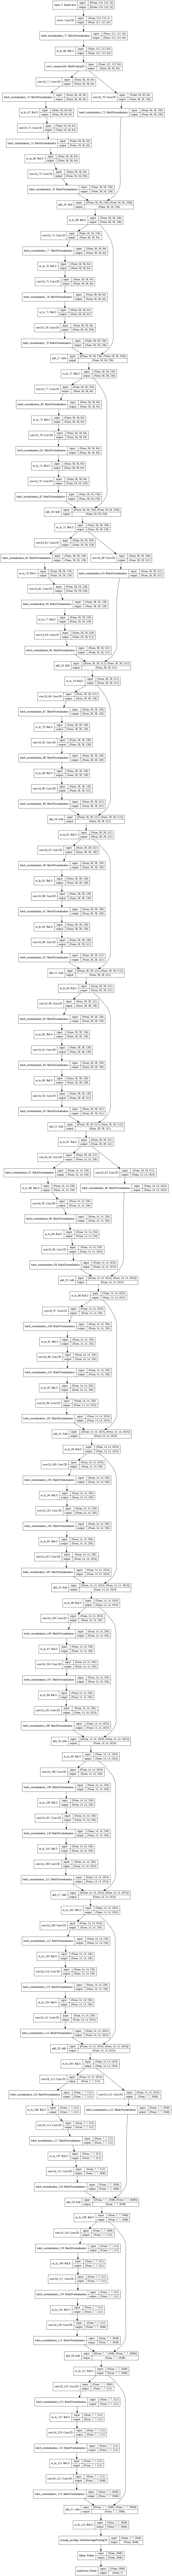

In [ ]:
resnet50 = build_resnet(input_shape=(224, 224, 3), is_50=True, num_classes=2)
resnet50.summary()
tf.keras.utils.plot_model(resnet50, show_shapes=True, dpi=70)

# 4.2 ResNet 50 Plain Model


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_125 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
re_lu_115 (ReLU)             (None, 112, 112, 64)      0         
_________________________________________________________________
conv1_maxpool2d (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_127 (Bat (None, 56, 56, 64)        256 

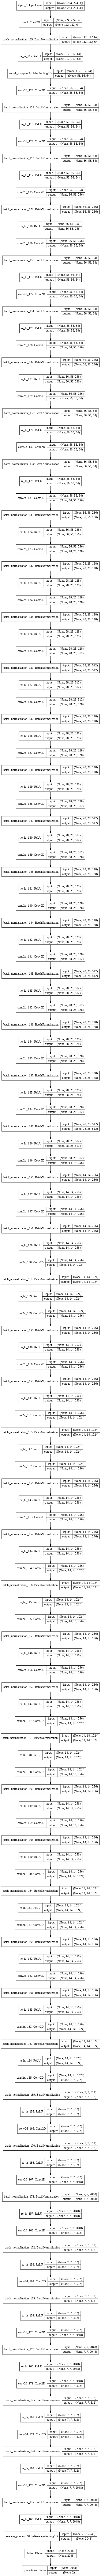

In [ ]:
resnet50_plain = build_resnet(input_shape=(224, 224, 3), is_plain=True, is_50=True, num_classes=2)
resnet50_plain.summary()
tf.keras.utils.plot_model(resnet50_plain, show_shapes=True, dpi=70)

# 4.3 ResNet 50 Plain and Residual Model Train


In [ ]:
BATCH_SIZE = 32
EPOCH = 50

# ResNet50 Plain
resnet50_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50_plain = resnet50_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
581/581 [==============================] - 112s 166ms/step - loss: 0.7014 - accuracy: 0.5335 - val_loss: 5.3308 - val_accuracy: 0.5110
Epoch 2/50
581/581 [==============================] - 96s 165ms/step - loss: 0.7014 - accuracy: 0.5323 - val_loss: 0.8194 - val_accuracy: 0.5041
Epoch 3/50
581/581 [==============================] - 96s 165ms/step - loss: 0.7015 - accuracy: 0.5362 - val_loss: 0.7909 - val_accuracy: 0.5262
Epoch 4/50
581/581 [==============================] - 95s 164ms/step - loss: 0.6974 - accuracy: 0.5434 - val_loss: 0.7454 - val_accuracy: 0.5349
Epoch 5/50
581/581 [==============================] - 96s 165ms/step - loss: 0.6986 - accuracy: 0.5327 - val_loss: 2.6649 - val_accuracy: 0.5346
Epoch 6/50
581/581 [==============================] - 96s 165ms/step - loss: 0.6975 - accuracy: 0.5377 - val_loss: 0.7034 - val_accuracy: 0.5535
Epoch 7/50
581/581 [==============================] - 96s 165ms/step - loss: 0.6975 - accuracy: 0.5375 - val_loss: 1.2044 - val_a

In [ ]:
# ResNet50 Residual
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50_residual = resnet50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
581/581 [==============================] - 130s 195ms/step - loss: 0.7008 - accuracy: 0.5793 - val_loss: 0.8213 - val_accuracy: 0.5371
Epoch 2/50
581/581 [==============================] - 112s 193ms/step - loss: 0.6764 - accuracy: 0.6065 - val_loss: 1.1386 - val_accuracy: 0.5181
Epoch 3/50
581/581 [==============================] - 112s 193ms/step - loss: 0.6622 - accuracy: 0.6253 - val_loss: 0.6604 - val_accuracy: 0.6093
Epoch 4/50
581/581 [==============================] - 112s 193ms/step - loss: 0.6508 - accuracy: 0.6331 - val_loss: 0.8336 - val_accuracy: 0.5548
Epoch 5/50
581/581 [==============================] - 112s 192ms/step - loss: 0.6485 - accuracy: 0.6327 - val_loss: 0.7217 - val_accuracy: 0.5861
Epoch 6/50
581/581 [==============================] - 112s 192ms/step - loss: 0.6361 - accuracy: 0.6469 - val_loss: 0.7858 - val_accuracy: 0.5742
Epoch 7/50
581/581 [==============================] - 112s 193ms/step - loss: 0.6255 - accuracy: 0.6594 - val_loss: 0.7948 -

# 4.4 ResNet 50 Plain and Residual Model Compare Result


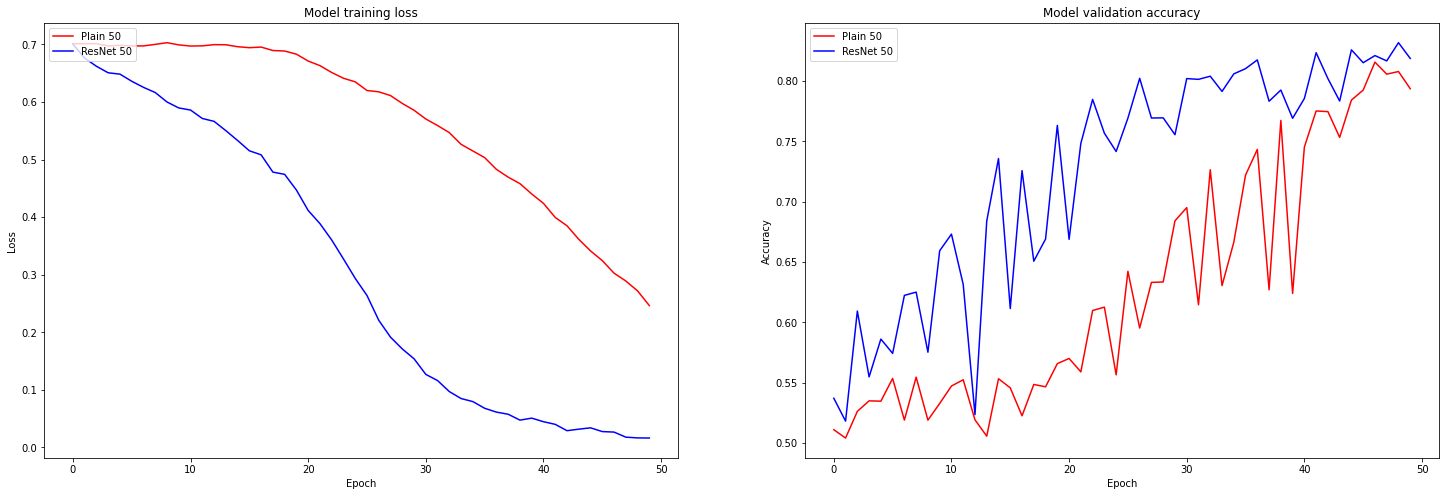

In [ ]:
# 시각화
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(25, 8))

plt.subplot(1, 2, 1)
plt.plot(history_50_plain.history['loss'], 'r')
plt.plot(history_50_residual.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Plain 50', 'ResNet 50'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_50_plain.history['val_accuracy'], 'r')
plt.plot(history_50_residual.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain 50', 'ResNet 50'], loc='best')
plt.show()

resnet 34 vs plain 34와는 validation accuracy에서 다른 양상을 보인다. 

여전히 과적합은 이루어지고 있으나 resnet50이 plain보다 더 좋은 모습을 보이고 있다.

# 5. ResNet 34 와 50 Compare

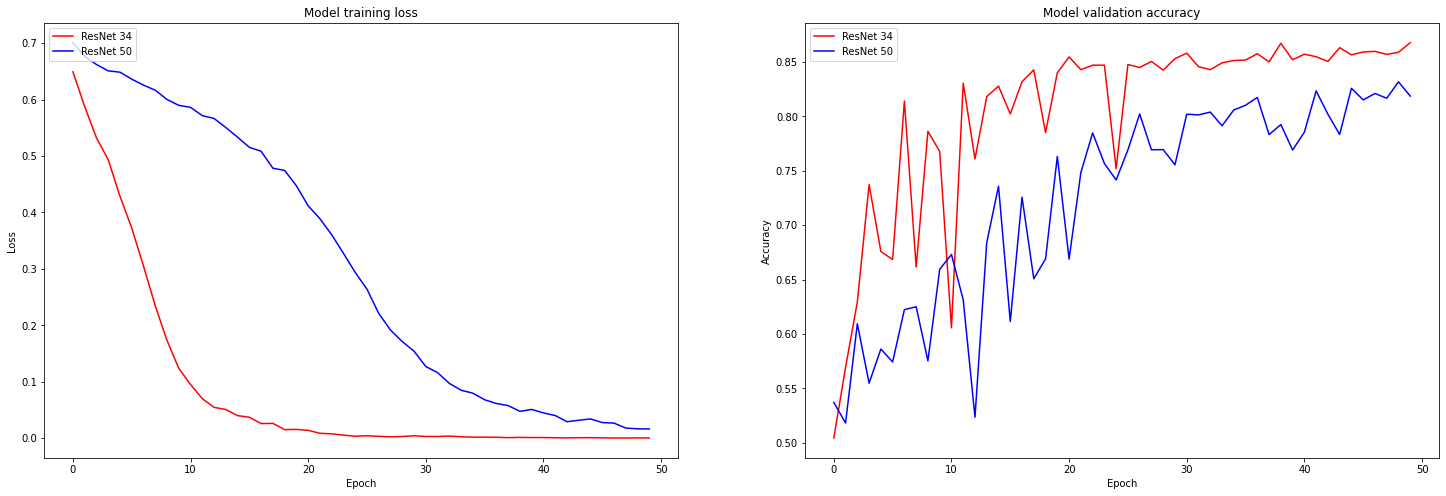

In [ ]:
figure = plt.figure(figsize=(25, 8))

plt.subplot(1, 2, 1)
plt.plot(history_34_residual.history['loss'], 'r')
plt.plot(history_50_residual.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet 34', 'ResNet 50'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_34_residual.history['val_accuracy'], 'r')
plt.plot(history_50_residual.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet 34', 'ResNet 50'], loc='upper left')
plt.show()

resnet34가 resnet50보다 좋은 이유를 생각해보면 model complexity가 resnet50이 높고 dataset은 더 낮은 model complexity를 보이기 때문이다.


# 6. Compare All Network

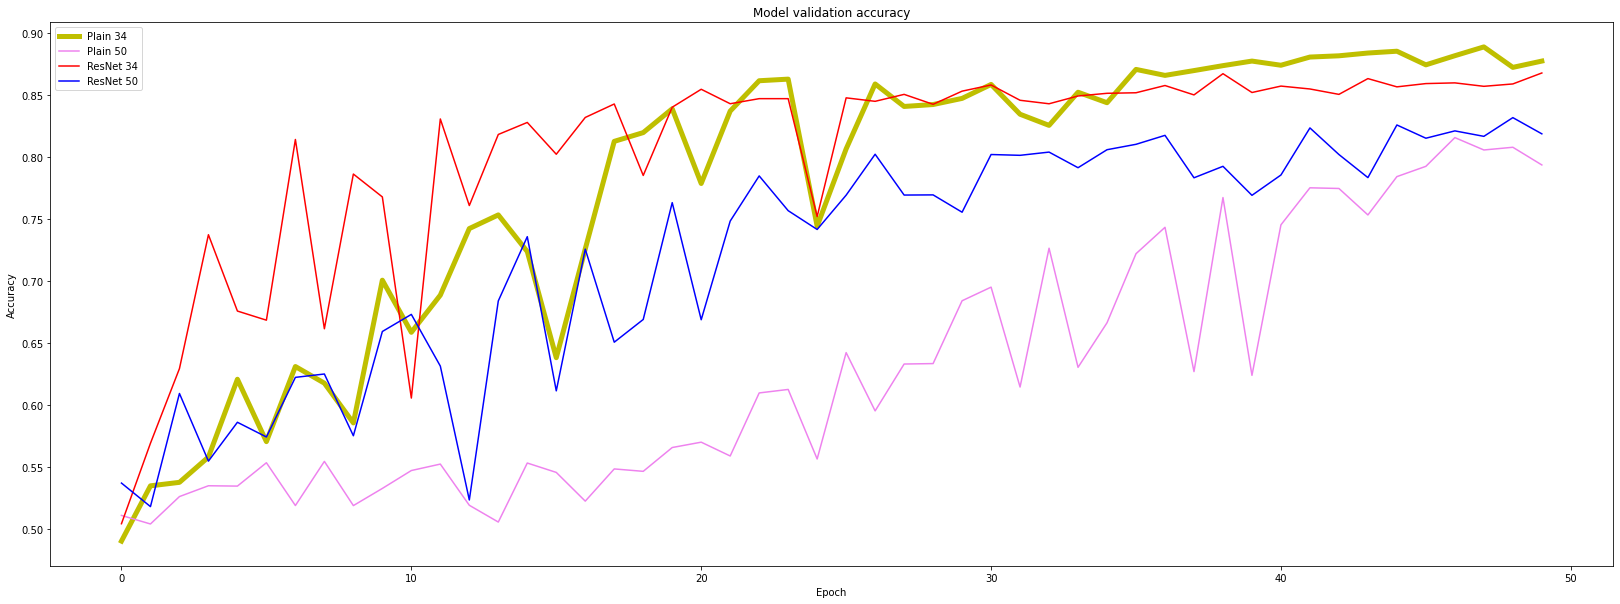

In [ ]:
figure = plt.figure(figsize=(28, 10))

plt.plot(history_34_plain.history['val_accuracy'], 'y', linewidth=5)
plt.plot(history_50_plain.history['val_accuracy'], 'violet')
plt.plot(history_34_residual.history['val_accuracy'], 'r', )
plt.plot(history_50_residual.history['val_accuracy'], 'b')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain 34', 'Plain 50', 'ResNet 34', 'ResNet 50'], loc='upper left')
plt.show()

plain34가 좋은 이유는 위에서 말했던 것과 마찬가지로 model complexity가 낮은 network를 요구하는 dataset이기에 가장 좋게 나왔다고 생각한다. ImageNet을 사용했다면 다른 결과가 나왔을 거라고 생각한다.

resnet이 plain보다 좋고 34가 50보다 더 좋은 양상을 보였을 것이다.

# 출처

https://github.com/museonghwang/AIFFEL/blob/master/GoingDeeper_02/Resnet_Ablation_Study.ipynb

# 회고

resnet을 구현하는 노드였는데 resnet을 머리로는 이해가 되지만 코딩에서 많은 어려움이 있었다. 그렇기 때문에 코딩적인 부분을 더 공부를 해야될 것 같다.